In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 3)})

In [4]:
chunkMap = pd.read_csv('data/ChunkMap.csv').set_index('ContestId')
workingData = pd.read_csv('data/WorkingData.csv').set_index('ContestId')

In [5]:
workingData = pd.merge(workingData, chunkMap, on='ContestId')

In [6]:
big = workingData[workingData['Entries'] > 1000]
bigNotFull = big[~(big['Entries'] == big['MaxNumberPlayers'])]

## Simple Contest

In [115]:
series1.to_csv('data/ForJackson/Contest1.csv')

In [116]:
series2.to_csv('data/ForJackson/Contest2.csv')

In [117]:
series3.to_csv('data/ForJackson/Contest3.csv')

In [52]:
series.to_csv('data/ForJackson/Contest5.csv')

In [49]:
contest = bigNotFull.iloc[39]
chunkDF = pd.read_csv('data/Chunks/'+contest.Chunk+'.csv').drop(columns=['Unnamed: 0'])
series = chunkDF[chunkDF['ContestId'] == contest.name][::-1]



In [50]:

series = series.assign(X = series.MinutesRemaining.max() - series.MinutesRemaining)
series = series.assign(Y = series.Entries.cumsum())
finalTime = series.X.max()
predictTime = finalTime-(60*4)

targetEntries = contest.MaxNumberPlayers

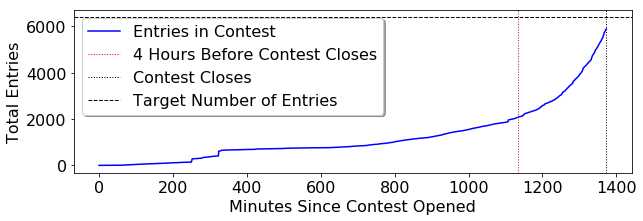

In [51]:
ax = plt.subplot()

ax.plot(series.X, series.Y, c='b', label='Entries in Contest')

ax.axvline(predictTime, ls=':', lw='1', c='r', label='4 Hours Before Contest Closes')
ax.axvline(finalTime, ls=':', lw='1', c='k', label='Contest Closes')
ax.axhline(targetEntries, ls='--', lw='1', c='k', label='Target Number of Entries')


ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Minutes Since Contest Opened')
plt.ylabel('Total Entries')

plt.show()

## Split at 4Hour Mark

In [7]:
contest = big.iloc[0]
chunkDF = pd.read_csv('data/Chunks/'+contest.Chunk+'.csv').drop(columns=['Unnamed: 0'])
series = chunkDF[chunkDF['ContestId'] == contest.name][::-1]
series = series.assign(X = series.MinutesRemaining.max() - series.MinutesRemaining)
series = series.assign(Y = series.Entries.cumsum())

finalTime = series.X.max()
predictTime = finalTime-(60*4)

X1 = list(series[series['MinutesRemaining'] >=60*4].X)
Y1 = list(series[series['MinutesRemaining'] >=60*4].Y)

X2 = list(series[series['MinutesRemaining'] <60*4].X)
Y2 = list(series[series['MinutesRemaining'] <60*4].Y)

targetEntries = contest.MaxNumberPlayers

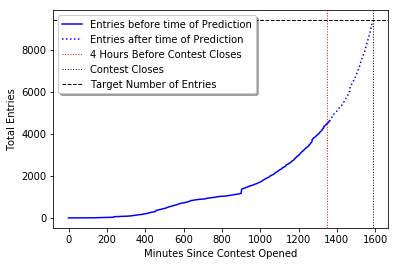

In [8]:
ax = plt.subplot()

ax.plot(X1, Y1, c = 'b', label='Entries before time of Prediction')
ax.plot(X2, Y2, c = 'b', ls=':', label='Entries after time of Prediction')

ax.axvline(predictTime, ls=':', lw='1', c='r', label='4 Hours Before Contest Closes')
ax.axvline(finalTime, ls=':', lw='1', c='k', label='Contest Closes')
ax.axhline(targetEntries, ls='--', lw='1', c='k', label='Target Number of Entries')

ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Minutes Since Contest Opened')
plt.ylabel('Total Entries')

plt.show()

### Kalman!

In [309]:
def kParameters(X, Y, QA, QB):
    random_state = np.random.RandomState(0)
    F = np.eye(2) #Transition Matrix (Identity Matrix)
    Z = Y #Observation matrix
    X0 = [[4.], [.0023]] #Inital parameters guess (?) <<<< NEED VALUES
    P0 = (np.eye(2) + random_state.randn(2, 2)*.1)*100*np.eye(2) #Covariance Matrix (The confidence in our prediction)
    R = 1
    Q = [[QA,0.],[0.,QB]]
    w = np.random.multivariate_normal([0., 0.], Q)
    return {'random_state':random_state, 'F':F, 'Z':Z, 'X0':X0, 'P0':P0, 'R':R, 'Q':Q, 'w':w}

def kalmanFilter(X, Y, parameters, extended=True, allX=False):
    Xs = []
    
    Pk = parameters['P0'] 
    Xk = parameters['X0'] 
    for n in range(0, len(X)):
        time, actual = X[n], Y[n]
        Pk = Pk + parameters["Q"]
                  
        Hk, Zk = 0, 0
        if(extended):
            part1 = np.exp(Xk[1][0]*time)
            Hk = [part1, part1*(Xk[0][0]*time)]
            Zk = Xk[0][0]*np.exp(Xk[1][0]*time)
        else:
            Hk = [1., time]
            Zk = np.dot(Hk, Xk) + np.random.normal(loc=0., scale=parameters['R']) #<----- Consider putting Vk instead of R        
        
        Yk = actual - Zk # residuals
        transposedH = [[Hk[0]],[Hk[1]]]
        Sk = np.dot(np.dot(Hk, Pk), transposedH)[0]+parameters['R']
        Kk = np.dot(Pk, transposedH)*(1/Sk)
        Xnext = Xk + Kk*Yk        
        p_part = (np.eye(2)-np.outer(Kk, Hk))
        Pnext = np.dot(p_part, Pk)
        Xs.append([Xk[0][0], Xk[1][0]])
        #Set new vars based on current observation
        Pk = Pnext
        Xk = Xnext
    if(len(Xs)==0):
        if(len(X) <240):
            return ['TooShort', 'TooShort']
        else:
            return [np.nan,np.nan]
    if(allX):
        return Xs
    else:
        return Xs[-1:][0]

In [335]:
contest = big.iloc[0]
chunkDF = pd.read_csv('data/Chunks/'+contest.Chunk+'.csv').drop(columns=['Unnamed: 0'])
series = chunkDF[chunkDF['ContestId'] == contest.name][::-1]
series = series.assign(X = series.MinutesRemaining.max() - series.MinutesRemaining)
series = series.assign(Y = series.Entries.cumsum())

series = series.assign(X_Scaled = 100 * series.X / series.X.max())
series = series.assign(Y_Scaled = 100 * series.Y / series.Y.max())

finalTime = series.X.max()
predictTime = finalTime-(60*4)
predictTime_Scaled = 100*predictTime/finalTime


X = list(series.X)
Y = list(series.Y)
XS = list(series.X_Scaled)
YS = list(series.Y_Scaled)

X1 = list(series[series['MinutesRemaining'] >60*4].X)
Y1 = list(series[series['MinutesRemaining'] >60*4].Y)
X1S = list(series[series['MinutesRemaining'] >60*4].X_Scaled)
Y1S = list(series[series['MinutesRemaining'] >60*4].Y_Scaled)

X2 = list(series[series['MinutesRemaining'] <60*4].X)
Y2 = list(series[series['MinutesRemaining'] <60*4].Y)
X2S = list(series[series['MinutesRemaining'] <60*4].X_Scaled)
Y2S = list(series[series['MinutesRemaining'] <60*4].Y_Scaled)

targetEntries = contest.MaxNumberPlayers


Qa = 10000
Qb = 100

ABs = kalmanFilter(X1S, Y1S, kParameters(X1S, Y1S, Qa, Qb), allX=True)
A, B = ABs[-1:][0]

modelX = np.arange(1, 101)
modelY = A * np.exp(modelX * B)

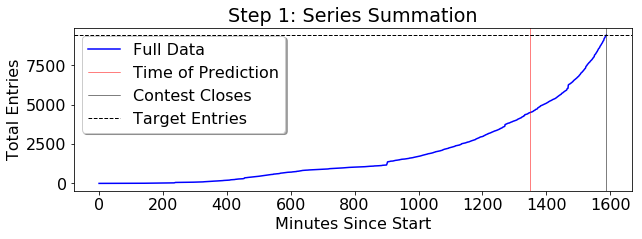

In [106]:
ax = plt.subplot()

ax.plot(X, Y, c = 'b', label='Full Data')

ax.axvline(predictTime, lw=.5, c='r', label='Time of Prediction')
ax.axvline(finalTime, lw=.5, c='k', label='Contest Closes')
ax.axhline(targetEntries, ls='--', lw=1, c='k', label='Target Entries')


ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Minutes Since Start')
plt.ylabel('Total Entries')
plt.title('Step 1: Series Summation')

plt.show()

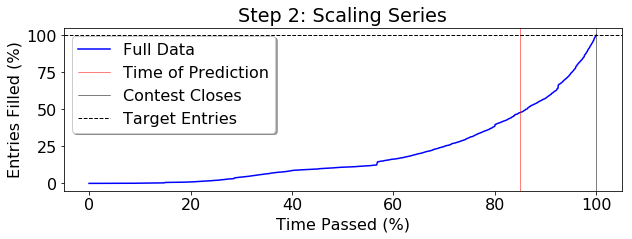

In [112]:
ax = plt.subplot()

ax.plot(XS, YS, c = 'b', label='Full Data')

ax.axvline(predictTime_Scaled, lw=.5, c='r', label='Time of Prediction')
ax.axvline(100, lw=.5, c='k', label='Contest Closes')
ax.axhline(100, ls='--', lw=1, c='k', label='Target Entries')


ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Time Passed (%)')
plt.ylabel('Entries Filled (%)')
plt.title('Step 2: Scaling Series')

plt.show()

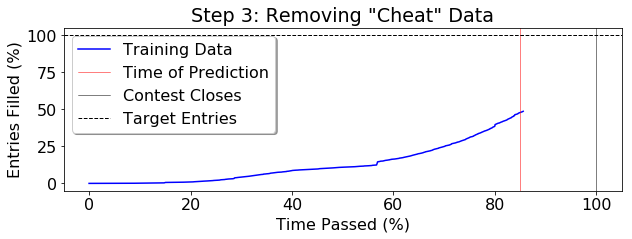

In [114]:
ax = plt.subplot()

ax.plot(X1S, Y1S, c = 'b', label='Training Data')

ax.axvline(predictTime_Scaled, lw=.5, c='r', label='Time of Prediction')
ax.axvline(100, lw=.5, c='k', label='Contest Closes')
ax.axhline(100, ls='--', lw=1, c='k', label='Target Entries')


ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Time Passed (%)')
plt.ylabel('Entries Filled (%)')
plt.title('Step 3: Removing "Cheat" Data')

plt.show()

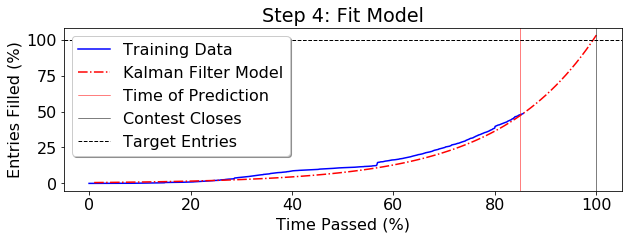

In [117]:
ax = plt.subplot()

ax.plot(X1S, Y1S, c = 'b', label='Training Data')
ax.plot(modelX, modelY, c = 'r', lw=1.5, ls='-.', label='Kalman Filter Model')

ax.axvline(predictTime_Scaled, lw=.5, c='r', label='Time of Prediction')
ax.axvline(100, lw=.5, c='k', label='Contest Closes')
ax.axhline(100, ls='--', lw=1, c='k', label='Target Entries')


ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Time Passed (%)')
plt.ylabel('Entries Filled (%)')
plt.title('Step 4: Fit Model')

plt.show()

### Varing Q

In [190]:
qrs = pd.read_csv('QR_Values.csv')

In [191]:
modelX = np.arange(1, 101)
modelYs = []
for i in range(0, len(qrs)):
    A, B = kalmanFilter(X1S, Y1S, kParameters(X1S, Y1S, qrs.iloc[i].Q1, qrs.iloc[i].Q2))
    modelYs.append(A * np.exp(modelX * B))

In [306]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': (10, 5)})

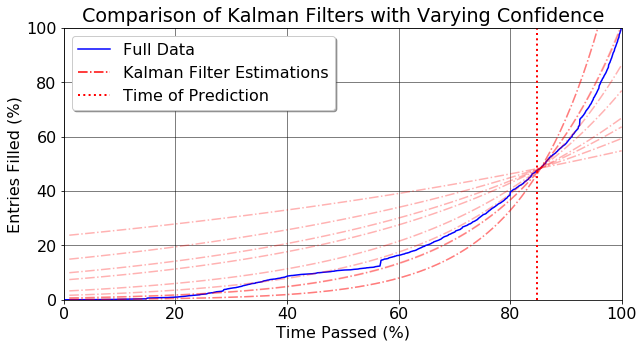

In [313]:
ax = plt.subplot()
ax.plot(XS, YS, c = 'b', label='Full Data')

ax.plot(X1S[-1:], Y1S[-1:], c = 'r', lw=1.5, ls='-.',alpha=1., label='Kalman Filter Estimations')

models = [0,1,2,3,4,5,6,10,13,14]
for i in models:
    ax.plot(modelX, modelYs[i], c = 'r', lw=1.5, ls='-.',alpha=.3, label='')

ax.axvline(predictTime_Scaled, lw=2.0, ls=':', c='r', label='Time of Prediction')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)



ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)

ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Time Passed (%)')
plt.ylabel('Entries Filled (%)')
plt.title('Comparison of Kalman Filters with Varying Confidence')

plt.show()

In [323]:
from colour import Color
colormap = list(Color("red").range_to(Color("green"),100))
def mapToColors(values):
    colors = []
    for v in values:
        i = int(v)
        colors.append(str(colormap[i]))
    return colors

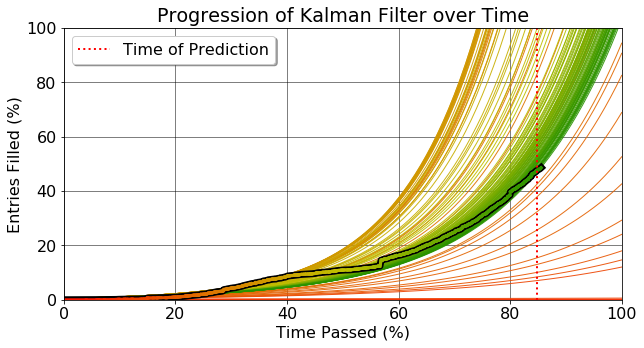

In [355]:
ax = plt.subplot()
# ax.plot(X1S, Y1S, c = 'b', label='Training Data')

for i in range(1, len(X1S), 7):
    A, B = ABs[i]
    modelX = np.arange(1, 101)
    modelY = A * np.exp(modelX * B)
    ax.plot(modelX, modelY,lw=1.0, alpha=.9, c = colors[i], label='')


ax.plot(X1S, Y1S, lw=7.0, c = 'k', label='')

colors = mapToColors(X1S)
for i in range(1, len(X1S)):
    ax.plot(X1S[i-1:i+1], Y1S[i-1:i+1], lw=3.0, c = colors[i], label='')
    


ax.axvline(predictTime_Scaled, lw=2.0, ls=':', c='r', label='Time of Prediction')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)



ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)

ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Time Passed (%)')
plt.ylabel('Entries Filled (%)')
plt.title('Progression of Kalman Filter over Time')

plt.show()

In [264]:
contest = big.iloc[0]
chunkDF = pd.read_csv('data/Chunks/'+contest.Chunk+'.csv').drop(columns=['Unnamed: 0'])
series = chunkDF[chunkDF['ContestId'] == contest.name][::-1]
series = series.assign(X = series.MinutesRemaining.max() - series.MinutesRemaining)
series = series.assign(Y = series.Entries.cumsum())

finalTime = series.X.max()
predictTime = finalTime-(60*4)
predictTime_Scaled = 100*predictTime/finalTime


X = list(series.X)
Y = list(series.Y)


targetEntries = contest.MaxNumberPlayers


In [270]:
plt.rcParams.update({'font.size': 12, 'figure.figsize': (6, 6)})

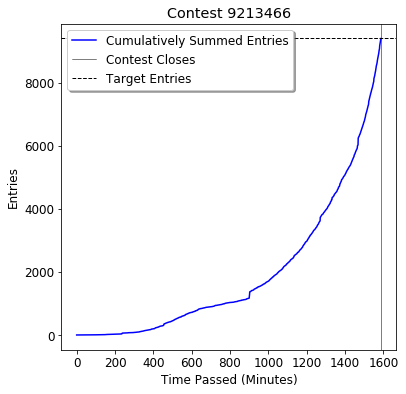

In [304]:
ax = plt.subplot()
ax.plot(X, Y, c = 'b', label='Cumulatively Summed Entries')

ax.axvline(finalTime, lw=.5, c='k', label='Contest Closes')
ax.axhline(targetEntries, ls='--', lw=1, c='k', label='Target Entries')


ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Time Passed (Minutes)')
plt.ylabel('Entries')
plt.title('Contest 9213466')

plt.show()

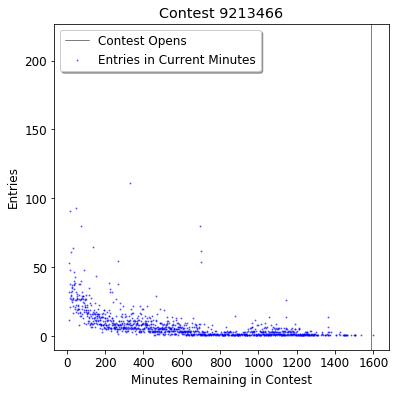

In [305]:
ax = plt.subplot()
ax.scatter(series.MinutesRemaining, series.Entries, c = 'b', s=1.0, alpha=.5, label='Entries in Current Minutes')

ax.axvline(finalTime, lw=.5, c='k', label='Contest Opens')

ax.legend(loc=2, framealpha = 1.0, shadow=True)
plt.xlabel('Minutes Remaining in Contest')
plt.ylabel('Entries')
plt.title('Contest 9213466')

plt.show()

### For KF/WLS Graphics

In [376]:
plt.rcParams.update({'font.size': 16, 'figure.figsize': (3, 3)})

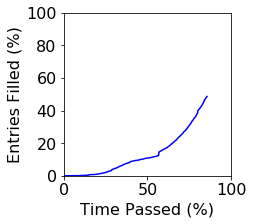

In [377]:
ax = plt.subplot()
ax.plot(X1S, Y1S, c = 'b', label='Full Data')

ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)

plt.xlabel('Time Passed (%)')
plt.ylabel('Entries Filled (%)')

plt.show()

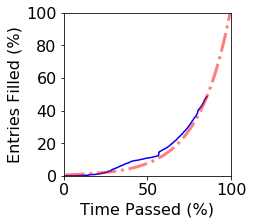

In [381]:
ax = plt.subplot()
ax.plot(X1S, Y1S, c = 'b', label='Full Data')
ax.plot(modelX, modelY, c = 'r', lw=3.0, ls='-.', alpha=.5, label='Kalman Filter Model')

ax.set_xlim(0, 100)
ax.set_ylim(0, 100)

# ax.grid(color='black', linestyle='-', linewidth=1, alpha=.5)

plt.xlabel('Time Passed (%)')
plt.ylabel('Entries Filled (%)')

plt.show()